In this notebook we compute the error for the solution obtained for a shuttling model (see notebook for Fig.14 for more information) by solving the ($\alpha,\beta$) hypergeometry, and the approximation for a basis of functions obtained with the LZ problem (see notebook for Fig.09 for more information). In this case, we use an interpolation technique, such that the approximated pulse is give by
$$
g(\tau) \simeq \sum_n\left[c_n^{(1)}\Theta(-\tau+1/2) + c_n^{(2)}\Theta(\tau-1/2)\right]\,\tilde{f}_n(\tau).
$$

In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import romb
from scipy.linalg import qr
from tqdm.auto import tqdm

from HQUAD_lib.parallel_utils import parameter_run
from HQUAD_lib.QUAD_utils import solve_LZ
from HQUAD_lib.hamiltonians import two_valleys_system
from HQUAD_lib.utils import compute_error_basis_approx

In [2]:
alphas = np.linspace(-25, 60, 201)  # Increase to obtain lower errors
alphas[0] = -np.inf
alphas[-1] = np.inf

beta = 0

zs_sol = parameter_run(solve_LZ, 'alpha', alphas, beta=beta, reduction=3)
s = np.linspace(0, 1, len(zs_sol[0]))

N = len(zs_sol)
ds = np.abs(s[1] - s[0])

G = np.zeros((N, N))

pbar = tqdm(range(N))
for i in pbar:
    G[i, :] = romb(zs_sol[i] * zs_sol, dx=ds, axis=-1)

Q, R, pivot_indices = qr(G, pivoting=True)
tolerance = 1e-10
rank = np.sum(np.abs(np.diag(R)) > tolerance)

independent_indices = sorted(pivot_indices[:rank])

independent_functions = [zs_sol[i] for i in independent_indices]

# Recompute the Gram matrix for the independent functions
G_independent = G[independent_indices, :][:, independent_indices]

solve_LZ: [['alpha']]:   0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

In [3]:
tc = 1
phiL = 0
phiR = 0.8 * np.pi
DeltaL = 1
DeltaR = 2

limit_inf = 0
limit_sup = 1e10

adiabatic_state = 1

In [19]:
eps_s = np.linspace(-10, 10, 2 ** 20 + 1)
driving_parameter = eps_s

partial_hamiltonian = np.array([two_valleys_system(1, 0, 0, 0, 0, 0) for _ in range(len(eps_s))])

hypermatrix = np.array([two_valleys_system(eps, tc, phiL, phiR, DeltaL, DeltaR) for eps in eps_s])
eigvalues, eigmodes = np.linalg.eigh(hypermatrix)

alphas = np.linspace(-3, 3, 21)  # Increase sample rate to improve resolution
betas = np.linspace(-3, 3, 21)  # Increase sample rate to improve resolution

In [20]:
parameters_fun = dict(eigvalues=eigvalues, eigmodes=eigmodes, driving_parameter=driving_parameter,
                      partial_hamiltonian=partial_hamiltonian, adiabatic_state=adiabatic_state,
                      independent_functions=independent_functions, G_independent=G_independent, limit_inf=limit_inf,
                      limit_sup=limit_sup)

errors = parameter_run(compute_error_basis_approx, [['alpha'], ['beta']], [[alphas], [betas]], **parameters_fun)
errors = errors.reshape((len(alphas), len(betas)))

compute_error_basis_approx: [['alpha'], (...)]:   0%|          | 0/441 [00:00<?, ?it/s]

/Users/david/opt/anaconda3/envs/main/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


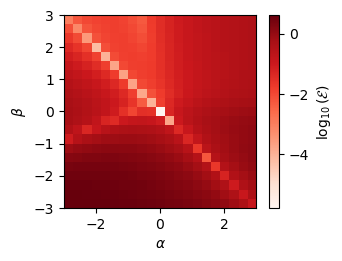

In [21]:
fig, ax = plt.subplots(figsize=(3.4, 2.5))

im = ax.imshow(np.log10(errors.T), origin='lower', extent=[min(alphas), max(alphas), min(betas), max(betas)],
               cmap='Reds')

cbar = plt.colorbar(im, label=r'$\log_{10}(\mathcal{E})$', ax=ax)

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$');